In [16]:
from omegaconf import OmegaConf
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from vqvae.models.foster import VectorQuantizedVariationalAutoencoder
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
%matplotlib inline

In [2]:
cfg = OmegaConf.load('configs/config.yaml')

In [3]:
datasets = {
    'train': MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True),
    'validation': MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=cfg.training.batch_size, shuffle=True),
    'validation': DataLoader(datasets['validation'], batch_size=cfg.training.batch_size, shuffle=True)
}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VectorQuantizedVariationalAutoencoder(**cfg.model)
model.load_state_dict(torch.load('checkpoints/model.pth'))
model.eval()
model.to(device)

VectorQuantizedVariationalAutoencoder(
  (encoder): Encoder(
    (conv2d_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=3136, out_features=8, bias=True)
    (leakyReLU): LeakyReLU(negative_slope=0.125)
    (dropout): Dropout(p=0.18, inplace=False)
  )
  (vq): VectorQuantizer()
  (decoder): Decoder(

In [5]:
columns = [f'z_{i}' for i in range(cfg.model.embedding_dim)] + ['Image']
df_embeddings = pd.DataFrame(columns=columns)
for k in range(cfg.model.num_embeddings):
    z = model.vq.embedding[k].unsqueeze(0)
    x_hat = model.decoder(z).reshape(1, 28, 28)
    img = transforms.ToPILImage()(x_hat)
    z = z.cpu().numpy().squeeze()
    df_embeddings.loc[k] = [*z, img]
df_embeddings

,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,Image
0,-0.397011,0.543097,0.357447,-0.224161,-0.297791,0.381621,0.465874,-0.241450,<PIL.Image.Image image mode=L size=28x28 at 0x...
1,0.068584,0.433204,-0.186097,0.534994,-0.567710,0.773323,-0.667128,0.537693,<PIL.Image.Image image mode=L size=28x28 at 0x...
2,-0.647692,0.207337,0.187740,-0.069199,0.077951,0.395682,0.061577,-0.573907,<PIL.Image.Image image mode=L size=28x28 at 0x...
3,0.205718,0.060293,-0.159861,0.522085,0.326480,-0.479859,0.804581,0.271787,<PIL.Image.Image image mode=L size=28x28 at 0x...
4,-0.442910,-0.540856,0.336370,-0.194227,0.054194,-0.197196,0.310471,-0.387113,<PIL.Image.Image image mode=L size=28x28 at 0x...
...,...,...,...,...,...,...,...,...,...
123,-0.074594,0.309142,0.296903,0.036743,-0.765097,0.445240,-0.351377,-0.481145,<PIL.Image.Image image mode=L size=28x28 at 0x...
124,-0.339599,-0.595164,0.421037,0.046243,-0.258301,-0.253949,-0.598465,0.011959,<PIL.Image.Image image mode=L size=28x28 at 0x...
125,0.027339,-0.107832,0.120256,0.415510,-0.446024,0.449331,-0.145865,-0.503725,<PIL.Image.Image image mode=L size=28x28 at 0x...
126,1.095395,0.038065,0.168987,-0.154605,0.300313,0.124603,0.295663,-0.308819,<PIL.Image.Image image mode=L size=28x28 at 0x...


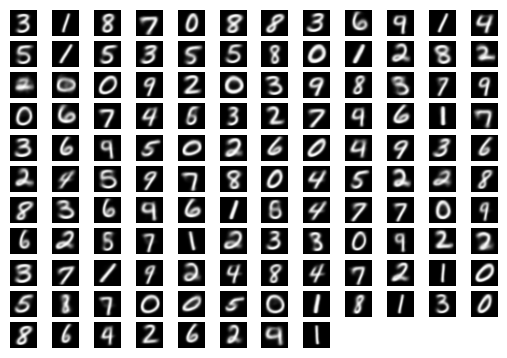

In [6]:
N = int(np.ceil(np.sqrt(cfg.model.num_embeddings)))

for i in range(cfg.model.num_embeddings):
    plt.subplot(N,N,i+1)
    plt.imshow(df_embeddings.loc[i,'Image'], cmap="gray")
    plt.axis('off')

In [19]:
columns = [f'z_{i}' for i in range(cfg.model.embedding_dim)] + ["Label", "Embedding_Index"]
df_latent_projection = pd.DataFrame(columns=columns)
row_idx = 0
for inputs, labels in tqdm(dataloaders['train']):
    zs = model.encoder(inputs.to(device))
    quantized, embedding_indices, _ = model.vq.encode(zs.unsqueeze(0))

    zs = zs.detach().cpu().numpy().squeeze()
    labels = labels.cpu().numpy().astype(int)
    embedding_indices = embedding_indices.detach().cpu().numpy().squeeze().astype(int)
    for z, label, embedding_index in zip(zs, labels, embedding_indices):
        df_latent_projection.loc[row_idx] = [*z, label, embedding_index]
        row_idx = row_idx + 1
df_latent_projection

100%|██████████| 59/59 [01:20<00:00,  1.36s/it]


,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,Label,Embedding_Index
0,-0.429199,0.318110,-0.070896,-0.052231,0.374990,0.233342,-0.054013,-0.029957,5.0,16.0
1,-0.118518,-0.061765,-0.559426,-0.233981,-0.316988,-1.361579,0.408851,-0.144539,0.0,107.0
2,-0.225452,0.225955,-0.186389,0.863783,-0.671780,0.747037,-0.644105,0.402447,1.0,77.0
3,0.989708,0.085693,0.407853,-0.141226,0.435321,0.224310,0.640512,-0.342271,9.0,126.0
4,0.674525,-0.190220,0.462017,-0.107230,0.293818,0.352016,0.076101,-0.163333,4.0,75.0
...,...,...,...,...,...,...,...,...,...,...
59995,-0.106158,0.011510,0.035587,0.849398,0.433050,0.024115,0.283189,0.345222,7.0,104.0
59996,0.437917,0.209738,-0.961382,0.622199,-0.327026,0.430178,0.529937,-0.298882,7.0,80.0
59997,0.872373,0.881145,0.113606,-0.220555,0.083778,-0.454804,0.744178,-0.795833,0.0,114.0
59998,-0.485665,0.040750,-0.410301,0.261423,0.076166,0.670601,-0.317271,-0.318973,8.0,102.0


In [15]:
import umap
reducer = umap.UMAP(n_neighbors=100)
z_data = df_latent_projection.drop(['Label','Embedding_Index'], axis=1).values
scaled_z_data = StandardScaler().fit_transform(z_data)
embedding = reducer.fit_transform(scaled_z_data)

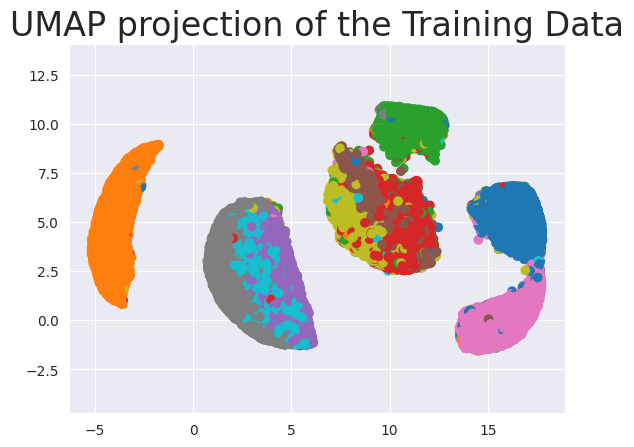

In [18]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df_latent_projection.Label.astype(int)])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Training Data', fontsize=24);